# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
from keras.regularizers import l2
import matplotlib.pyplot as plt
import io
from PIL import Image
from keras.utils import to_categorical
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3

### Data Loading and Preprocessing

In [ ]:
data_dir = "/kaggle/input/brain-tumor-classification-mri/Training"
test_data_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'

class_names = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

def load_data(data_directory):
    images = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(class_dir, filename)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(class_idx)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load the data
X, y = load_data(data_dir)
X_test, y_test = load_data(test_data_dir)

# Normalize the pixel values
X = X / 255.0
X_test = X_test / 255.0
# Convert class vectors to binary class matrices
y = to_categorical(y, num_classes=len(class_names))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare iterators
train_gen = data_gen.flow(X_train, y_train, batch_size=32)
val_gen = data_gen.flow(X_val, y_val, batch_size=32)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import feature, morphology
from keras.preprocessing.image import ImageDataGenerator

X_hog = np.array([feature.hog(img, block_norm='L2-Hys', visualize=False) for img in X])
X_morph = np.array([morphology.binary_erosion(img) for img in X])

In [ ]:
def preprocess(X):
    X_morph = np.array([morphology.binary_erosion(img) for img in X])
    X_combined = np.concatenate([X, X_morph], axis=-1)
    return X_combined[:,:,:,:3],X_combined[:,:,:,3:]

X_test_1, X_test_2 = preprocess(X_test)

In [ ]:
# Concatenate the original images with the extracted features
X_combined = np.concatenate([X, X_morph], axis=-1)

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare iterators
train_gen = data_gen.flow(X_train, y_train, batch_size=32)
val_gen = data_gen.flow(X_val, y_val, batch_size=32)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2296, 224, 224, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (574, 224, 224, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
from skimage import feature, morphology
from keras.preprocessing.image import ImageDataGenerator

X_hog = np.array([feature.hog(img, block_norm='L2-Hys', visualize=False) for img in X])
X_morph = np.array([morphology.binary_erosion(img) for img in X])

X_combined = np.concatenate([X, X_morph], axis=-1)

X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [ ]:
X_train_1,X_train_2 = X_train[:,:,:,:3],X_train[:,:,:,3:]
X_val_1,X_val_2 = X_val[:,:,:,:3],X_val[:,:,:,3:]

data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = data_gen.flow(X_train_1, y_train, batch_size=32)
val_gen = data_gen.flow(X_val_1, y_val, batch_size=32)

## Baseline Model Training (Model 1)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)            

In [ ]:
# Define a callback to prevent overfitting
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Epoch 1/30
72/72 [==============================] - 29s 404ms/step - loss: 1.4121 - accuracy: 0.3647 - val_loss: 1.1419 - val_accuracy: 0.4861
Epoch 2/30
72/72 [==============================] - 29s 403ms/step - loss: 1.1431 - accuracy: 0.4891 - val_loss: 1.0109 - val_accuracy: 0.5453
Epoch 3/30
72/72 [==============================] - 29s 402ms/step - loss: 1.0260 - accuracy: 0.5464 - val_loss: 0.9655 - val_accuracy: 0.5557
Epoch 4/30
72/72 [==============================] - 29s 398ms/step - loss: 0.9765 - accuracy: 0.5673 - val_loss: 0.8583 - val_accuracy: 0.6307
Epoch 5/30
72/72 [==============================] - 29s 401ms/step - loss: 0.8881 - accuracy: 0.6070 - val_loss: 0.8428 - val_accuracy: 0.6237
Epoch 6/30
72/72 [==============================] - 29s 396ms/step - loss: 0.8572 - accuracy: 0.6260 - val_loss: 0.8543 - val_accuracy: 0.6307
Epoch 7/30
72/72 [==============================] - 29s 398ms/step - loss: 0.7963 - accuracy: 0.6608 - val_loss: 0.7946 - val_accuracy: 0.6707

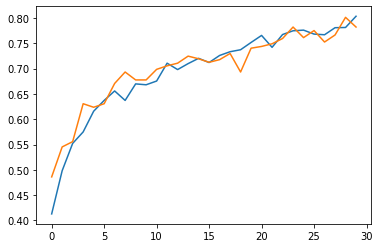

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

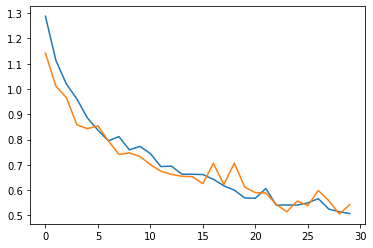

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
# Predict the labels for the training set
y_train_pred = model.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Training Accuracy: 77.22%
Validation Accuracy: 75.26%


## ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model without the top (fully connected) layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the ResNet50 base model
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True
# Create a custom small model on top of the ResNet50 base
model3 = models.Sequential()
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes for classification

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model3.summary()

history = model3.fit(X_train_1,y_train,epochs=50,validation_data=val_gen)

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 49,279,108
Trainable params: 30,157,060
Non-trainable params: 19,122,048
_________________________________________________________________
Epoch 1/50
72/72 [================

In [ ]:
# Predict the labels for the training set
y_train_pred = model3.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Training Accuracy: 64.20%
Validation Accuracy: 75.26%


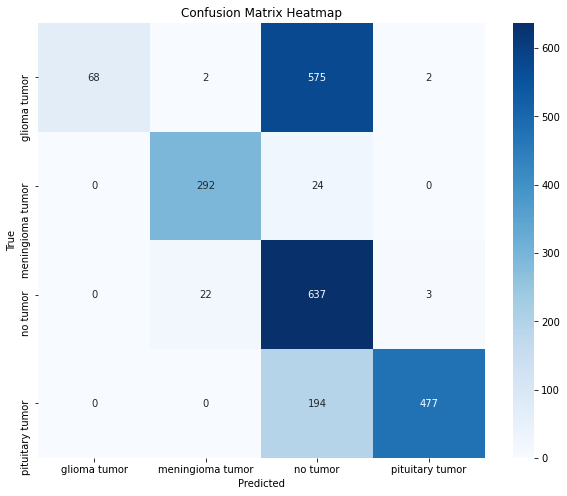

In [ ]:
# Generate predictions
y_pred_probs = model3.predict(X_train_1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Custom CNN Model (Model 2)

In [ ]:
from tensorflow.keras.optimizers import SGD

model = Sequential()

# Convolutional layer 1
model.add(Conv2D(64,(7,7), input_shape=(224, 224, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

 # Convolutional layer 5
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 6
model.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Full connect layers

model.add(Dense(units= 1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=4, activation='softmax'))


model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

In [ ]:
model_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model_mcp = ModelCheckpoint(filepath = 'model_weights.h5', monitor = 'val_categorical_accuracy',
                      save_best_only = True, verbose = 1)

history = model.fit(X_train_1,y_train, epochs=10, validation_data=val_gen, validation_steps= 1311//32,
                     callbacks=[model_es, model_rlr, model_mcp])

Epoch 1/10
72/72 [==============================] - 162s 2s/step - loss: 1.1483 - categorical_accuracy: 0.5858 - val_loss: 1.4289 - val_categorical_accuracy: 0.2718

Epoch 00001: val_categorical_accuracy improved from -inf to 0.27178, saving model to model_weights.h5
Epoch 2/10
72/72 [==============================] - 119s 2s/step - loss: 0.6119 - categorical_accuracy: 0.7500
Epoch 3/10
72/72 [==============================] - 119s 2s/step - loss: 0.4243 - categorical_accuracy: 0.8336
Epoch 4/10
72/72 [==============================] - 119s 2s/step - loss: 0.2408 - categorical_accuracy: 0.9068
Epoch 6/10
72/72 [==============================] - 119s 2s/step - loss: 0.1702 - categorical_accuracy: 0.9395
Epoch 7/10
72/72 [==============================] - 119s 2s/step - loss: 0.1365 - categorical_accuracy: 0.9560
Epoch 8/10
72/72 [==============================] - 119s 2s/step - loss: 0.1063 - categorical_accuracy: 0.9678
Epoch 9/10
72/72 [==============================] - 119s 2s/step -

In [ ]:
# Predict the labels for the training set
y_train_pred = model.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

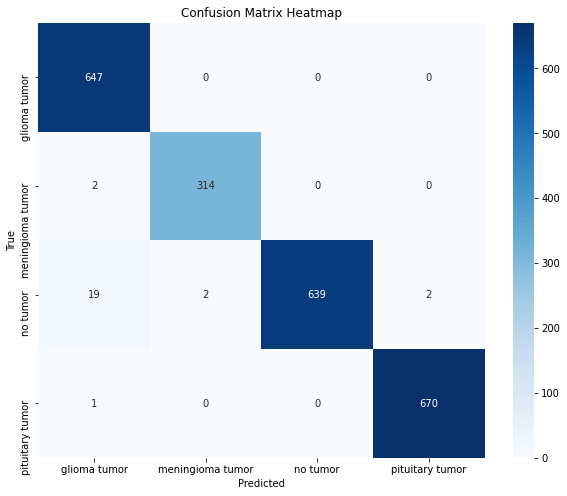

In [ ]:
# Generate predictions
y_pred_probs = model.predict(X_train_1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
